In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklift.models import TwoModels, ClassTransformation
from sklift.metrics import uplift_at_k
from scipy.stats import ttest_rel
from sklift.viz import plot_qini_curve
import optuna
from sklift.viz import plot_uplift_by_percentile
import warnings
warnings.filterwarnings('ignore')

## Построение ML модели

In [11]:
# Импорт данных
from sklift.datasets import fetch_x5
dataset = fetch_x5()

clients_df = dataset.data.clients
clients_df = clients_df.set_index('client_id')

purchases_df = dataset.data.purchases
purchases_df = purchases_df.set_index('client_id')

train_df = pd.DataFrame(data= np.c_[dataset.data.train, dataset.treatment, dataset.target],
                     columns= dataset.feature_names.train_features)
train_df = train_df.set_index('client_id')

In [12]:
# Извлечение признаков
features_df = clients_df.copy()
features_df['first_issue_time'] = (pd.to_datetime(features_df['first_issue_date'])
                                   - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
features_df['first_redeem_time'] = (pd.to_datetime(features_df['first_redeem_date'])
                                   - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
features_df['issue_redeem_delay'] = features_df['first_redeem_time'] - features_df['first_issue_time']
features_df = features_df.drop(['first_issue_date', 'first_redeem_date'], axis=1)

avr_check = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['purchase_sum'].mean()
num_purchases = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['transaction_id'].count()
points_spent = -(purchases_df.drop_duplicates('transaction_id').groupby('client_id')['regular_points_spent'].sum() + purchases_df.drop_duplicates('transaction_id').groupby('client_id')['express_points_spent'].sum())
num_stores = purchases_df.drop_duplicates('transaction_id').groupby('client_id')['store_id'].nunique()

features_df['avr_check'] = features_df.index.map(avr_check)
features_df['num_purchases'] = features_df.index.map(num_purchases)
features_df['points_spent'] = features_df.index.map(points_spent)
features_df['num_stores'] = features_df.index.map(num_stores) # Новый признак: кол-во уникально посещеных магазинов

train_df = train_df.astype('int64')

In [ ]:
# Проверка пропущенных значений в признаках
features_df.isnull().sum()

In [5]:
bad_data = features_df[(features_df['age'] > 120) | (features_df['age'] < 0) | (features_df['issue_redeem_delay'] < 0)].index

In [6]:
# Избавляемся от некорректных строчек в feature и train
features_df = features_df.drop(bad_data, axis=0)
train_df = train_df.drop(train_df.index.intersection(bad_data), axis=0)

После серии эксперементов, было обнаружено, что если заменить пропущенные значения на максимальные, модель будет учитывать сгенерированный выброс, что ухудшает качество.

In [7]:
drop_nan = features_df[features_df.isnull().any(1)].index

In [8]:
# Выбрасываем строчки с NaN
features_df.drop(labels=drop_nan, axis=0, inplace=True)
train_df.drop(train_df.index.intersection(drop_nan), axis=0, inplace=True)

In [9]:
# Заменяем пропущенные значения в first_redeem_time и issue_redeem_delay на максимальные
# features_df['first_redeem_time'] = features_df['first_redeem_time'].fillna(features_df['first_redeem_time'].max())
# features_df['issue_redeem_delay'] = features_df['first_redeem_time'] - features_df['first_issue_time']

In [10]:
features_df.isnull().sum()

age                   0
gender                0
first_issue_time      0
first_redeem_time     0
issue_redeem_delay    0
avr_check             0
num_purchases         0
points_spent          0
num_stores            0
dtype: int64

In [11]:
# Создание hold out выборки
indices_learn, indices_valid = train_test_split(train_df.index, test_size=0.20)

X_train = features_df.loc[indices_learn, :]
y_train = train_df.loc[indices_learn, 'target']
treat_train = train_df.loc[indices_learn, 'treatment_flg']

X_ho = features_df.loc[indices_valid, :]
y_ho = train_df.loc[indices_valid, 'target']
treat_ho = train_df.loc[indices_valid, 'treatment_flg']

Оценим насколько трансформация классов будет "стабильно" лучше метода двух моделей. Для этого посчитаем t-критерий Стьюдента для связанных выборок и p-value.

In [12]:
# Для CatBoost
cat_features = ['gender']

model1 = TwoModels(
    estimator_trmnt = CatBoostClassifier(num_trees=30, random_state=321, nan_mode='Forbidden', logging_level='Silent'),
    estimator_ctrl = CatBoostClassifier(num_trees=30, random_state=321, nan_mode='Forbidden', logging_level='Silent'),
    method = 'vanilla'
)
model2 = ClassTransformation(CatBoostClassifier(num_trees=30, random_state=321, nan_mode='Forbidden', logging_level='Silent'))

scores_two_models = np.array([])
scores_ct_model = np.array([])

for i in range(30):
    
    train_indices, test_indices = train_test_split(y_train.index, test_size=0.3, random_state=i*10)
        
    train_x = X_train.loc[train_indices, :]
    train_y = y_train.loc[train_indices]
    train_treat = treat_train.loc[train_indices]

    test_x = X_train.loc[test_indices, :]
    test_y = y_train.loc[test_indices]
    test_treat = treat_train.loc[test_indices]

    model1 = model1.fit(
        train_x, train_y, train_treat,
        estimator_trmnt_fit_params={'cat_features': cat_features}, 
        estimator_ctrl_fit_params={'cat_features': cat_features}
    )

    uplift_model1 = model1.predict(test_x)
    uplift_at_score1 = uplift_at_k(y_true=test_y, uplift=uplift_model1, treatment=test_treat, strategy='overall', k=0.3)

    scores_two_models = np.append(scores_two_models, uplift_at_score1)

    model2 = model2.fit(
        train_x, train_y, train_treat,
        estimator_fit_params={'cat_features': cat_features},
    )

    uplift_model2 = model2.predict(test_x)
    uplift_at_score2 = uplift_at_k(y_true=test_y, uplift=uplift_model2, treatment=test_treat, strategy='overall', k=0.3)

    scores_ct_model = np.append(scores_ct_model, uplift_at_score2)

In [13]:
ttest_rel(scores_two_models, scores_ct_model) 

Ttest_relResult(statistic=-1.3120392690454925, pvalue=0.19979820436248402)

Как видим, p-value не позволяет отвергнуть нулевую гипотезу, так что будем применять метод с двумя независимыми моделями.

In [14]:
# Подбор гиперпараметров, используя библиотеку Optuna
def objective(trial):
    train_indices, test_indices = train_test_split(y_train.index, test_size=0.3)
    
    train_x = X_train.loc[train_indices, :]
    train_y = y_train.loc[train_indices]
    train_treat = treat_train.loc[train_indices]

    test_x = X_train.loc[test_indices, :]
    test_y = y_train.loc[test_indices]
    test_treat = treat_train.loc[test_indices]
    
    params = {
        'verbose': False,
        'num_trees': trial.suggest_int('num_trees', 50, 150, step=10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, step=0.01),
        'depth': trial.suggest_int('depth', 2, 8, step=2),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 3.5, step=0.5)
    }
    
    two_models = TwoModels(CatBoostClassifier(**params), CatBoostClassifier(**params))
    two_models.fit(
        train_x, train_y, train_treat,
        estimator_trmnt_fit_params={'cat_features': cat_features},
        estimator_ctrl_fit_params={'cat_features': cat_features}
    )
    
    uplift_two_models = two_models.predict(test_x)
    uplift_tm_score = uplift_at_k(y_true=test_y, uplift=uplift_two_models, treatment=test_treat, strategy='overall', k=0.3)
    return uplift_tm_score

In [15]:
study_ct = optuna.create_study(direction='maximize')
study_ct.optimize(objective, timeout=750, show_progress_bar=True)

[I 2021-08-25 16:04:56,040] A new study created in memory with name: no-name-4967d857-a19a-4dc7-a7c3-8f0667cc6b46


[I 2021-08-25 16:05:12,141] Trial 0 finished with value: 0.0750870645444579 and parameters: {'num_trees': 130, 'learning_rate': 0.01, 'depth': 6, 'l2_leaf_reg': 1.5}. Best is trial 0 with value: 0.0750870645444579.
[I 2021-08-25 16:05:17,439] Trial 1 finished with value: 0.07475408056691446 and parameters: {'num_trees': 100, 'learning_rate': 0.12, 'depth': 2, 'l2_leaf_reg': 2.0}. Best is trial 0 with value: 0.0750870645444579.
[I 2021-08-25 16:05:30,671] Trial 2 finished with value: 0.08453176028353493 and parameters: {'num_trees': 150, 'learning_rate': 0.18000000000000002, 'depth': 4, 'l2_leaf_reg': 2.0}. Best is trial 2 with value: 0.08453176028353493.
[I 2021-08-25 16:05:45,517] Trial 3 finished with value: 0.060852281922452844 and parameters: {'num_trees': 90, 'learning_rate': 0.31, 'depth': 8, 'l2_leaf_reg': 3.0}. Best is trial 2 with value: 0.08453176028353493.
[I 2021-08-25 16:06:01,134] Trial 4 finished with value: 0.08228768326697466 and parameters: {'num_trees': 130, 'learnin

[I 2021-08-25 16:10:32,452] Trial 36 finished with value: 0.05764366603951654 and parameters: {'num_trees': 100, 'learning_rate': 0.23, 'depth': 4, 'l2_leaf_reg': 2.0}. Best is trial 8 with value: 0.08687411237526454.
[I 2021-08-25 16:10:38,455] Trial 37 finished with value: 0.08082939495412478 and parameters: {'num_trees': 120, 'learning_rate': 0.11, 'depth': 2, 'l2_leaf_reg': 1.5}. Best is trial 8 with value: 0.08687411237526454.
[I 2021-08-25 16:10:46,039] Trial 38 finished with value: 0.0774502712519548 and parameters: {'num_trees': 60, 'learning_rate': 0.03, 'depth': 6, 'l2_leaf_reg': 1.0}. Best is trial 8 with value: 0.08687411237526454.
[I 2021-08-25 16:11:00,132] Trial 39 finished with value: 0.05620738143629067 and parameters: {'num_trees': 90, 'learning_rate': 0.36000000000000004, 'depth': 8, 'l2_leaf_reg': 3.0}. Best is trial 8 with value: 0.08687411237526454.
[I 2021-08-25 16:11:13,426] Trial 40 finished with value: 0.08055980159284615 and parameters: {'num_trees': 150, 'le

[I 2021-08-25 16:15:46,299] Trial 71 finished with value: 0.08732015178061359 and parameters: {'num_trees': 120, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 1.5}. Best is trial 54 with value: 0.10254231703106459.
[I 2021-08-25 16:16:05,805] Trial 72 finished with value: 0.08092535602402007 and parameters: {'num_trees': 120, 'learning_rate': 0.060000000000000005, 'depth': 8, 'l2_leaf_reg': 1.0}. Best is trial 54 with value: 0.10254231703106459.
[I 2021-08-25 16:16:26,805] Trial 73 finished with value: 0.08401792540644337 and parameters: {'num_trees': 130, 'learning_rate': 0.01, 'depth': 8, 'l2_leaf_reg': 1.5}. Best is trial 54 with value: 0.10254231703106459.
[I 2021-08-25 16:16:46,449] Trial 74 finished with value: 0.08499703565918049 and parameters: {'num_trees': 120, 'learning_rate': 0.09, 'depth': 8, 'l2_leaf_reg': 1.0}. Best is trial 54 with value: 0.10254231703106459.
[I 2021-08-25 16:17:04,770] Trial 75 finished with value: 0.07935187858594484 and parameters: {'num_trees': 

In [16]:
# Вывод лучших гиперпараметров
study_ct.best_params

{'num_trees': 110, 'learning_rate': 0.09, 'depth': 2, 'l2_leaf_reg': 1.0}

Обучим модель и оценим ее на отдельной выборке.

In [17]:
tm_model = TwoModels(
    CatBoostClassifier(**study_ct.best_params, verbose=False),
    CatBoostClassifier(**study_ct.best_params, verbose=False),
    method='vanilla'
)

In [18]:
tm_model = tm_model.fit(
        X_train, y_train, treat_train,
        estimator_trmnt_fit_params={'cat_features': cat_features},
        estimator_ctrl_fit_params={'cat_features': cat_features}
)

## Валидация модели

In [19]:
tm_uplift = tm_model.predict(X_ho)
uplift_at_score = uplift_at_k(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_score:.4f}")

Uplift@30%: 0.0839


Прирост по сравнению с baseline составил 0,0052

Выведем важность признаков

In [21]:
features_imp_trmnt = pd.DataFrame({
    'feature_name': tm_model.estimator_trmnt.feature_names_,
    'feature_score': tm_model.estimator_trmnt.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

features_imp_trmnt

,feature_name,feature_score
0,num_purchases,65.209282
1,first_redeem_time,27.992520
2,first_issue_time,4.158931
3,age,1.884279
4,avr_check,0.210992
5,gender,0.187816
6,issue_redeem_delay,0.144602
7,num_stores,0.117877
8,points_spent,0.093701


In [23]:
features_imp_ctrl = pd.DataFrame({
    'feature_name': tm_model.estimator_ctrl.feature_names_,
    'feature_score': tm_model.estimator_ctrl.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

features_imp_ctrl

,feature_name,feature_score
0,num_purchases,87.805923
1,first_issue_time,5.582086
2,first_redeem_time,4.895462
3,age,0.714433
4,points_spent,0.583007
5,num_stores,0.200062
6,avr_check,0.130909
7,issue_redeem_delay,0.088118
8,gender,0.000000


Оценим модель по сегментам. Как она будет работать на пользователях моложе или старше 50 лет.

In [32]:
segment1_x = X_ho[features_df['age'] < 50]
segment1_y = y_ho[features_df['age'] < 50]
segment1_tr = treat_ho[features_df['age'] < 50]

seg1_uplift = tm_model.predict(segment1_x)
uplift_at_seg1 = uplift_at_k(y_true=segment1_y, uplift=seg1_uplift, treatment=segment1_tr, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_seg1:.4f}")

Uplift@30%: 0.0561


In [33]:
segment2_x = X_ho[features_df['age'] > 50]
segment2_y = y_ho[features_df['age'] > 50]
segment2_tr = treat_ho[features_df['age'] > 50]

seg2_uplift = tm_model.predict(segment2_x)
uplift_at_seg2 = uplift_at_k(y_true=segment2_y, uplift=seg2_uplift, treatment=segment2_tr, strategy='overall', k=0.3)
print(f"Uplift@30%: {uplift_at_seg2:.4f}")

Uplift@30%: 0.1120


Как видно, модель в среднем лучше работает на пользователях старше 50 лет, и в среднем работает хуже на более молодых клиентах.

<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0304'}, xlabel='Percentile', ylabel='Uplift = treatment response rate - control response rate'>

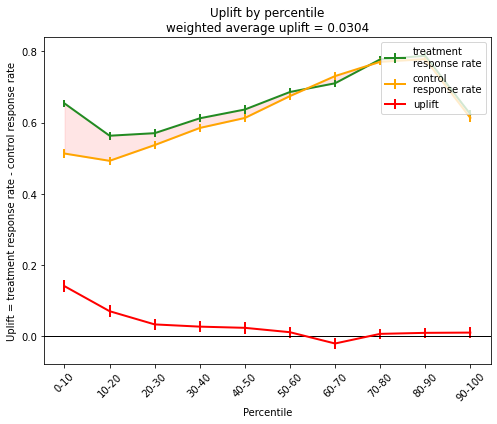

In [38]:
plot_uplift_by_percentile(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, strategy='overall', kind='line')

array([<AxesSubplot:title={'center':'Uplift by percentile\nweighted average uplift = 0.0304'}>,
       <AxesSubplot:title={'center':'Response rate by percentile'}, xlabel='Percentile'>],
      dtype=object)

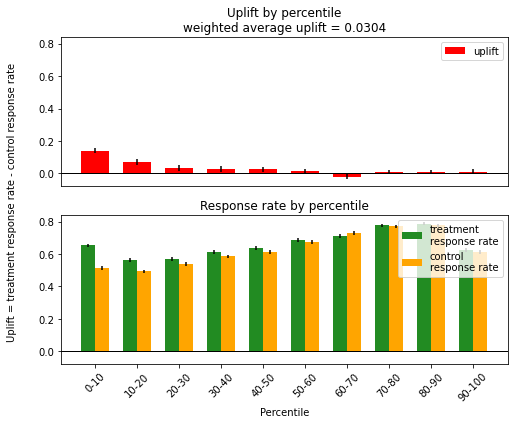

In [39]:
plot_uplift_by_percentile(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, strategy='overall', kind='bar')

Из графиков видно, что модель лучше ранжирует пользователей и ставит группу "внушаемых" в начало.

<AxesSubplot:title={'center':'Qini curve\nqini_auc_score=0.0250'}, xlabel='Number targeted', ylabel='Number of incremental outcome'>

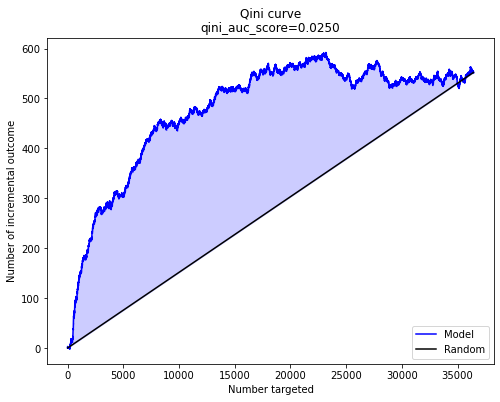

In [41]:
plot_qini_curve(y_true=y_ho, uplift=tm_uplift, treatment=treat_ho, perfect=False)

Наша модель работает лучше, чем случайная, то есть результаты отличаются от простого угадывания.